In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


### Data Preprocess

In [3]:
# wrangle function
def wrangle(filepath):
    # Read csv file into Data Frame
    df = pd.read_csv(filepath)
    # Clean column names
    df = df.rename(columns=lambda x: x.strip().strip('"'))

# Rename columns
    df['pilotstate'] = df['pilotstate(EV_DISCONNECTED = \'A\'_EV_CONNECTED = \'B1\'_WAITING_FOR_EV = \'B2\'_STOP_MODE = \'C1\'_CHARGING_MAX_POWER = \'C2\'_FAULT_RESTART = \'F\'']
    df['loadcontrolgridimportexport-n'] = df['zappimode(1=FAST.2=ECO.3=ECO+)']
    df['zappimode'] = df[')']
    df['dsrdataload-n'] = df['loadcontrolgridimportexport']
    df['dsrdataseconds-n'] = df['dsrdataload']

# Drop redundant columns
    df.drop(columns=['pilotstate(EV_DISCONNECTED = \'A\'_EV_CONNECTED = \'B1\'_WAITING_FOR_EV = \'B2\'_STOP_MODE = \'C1\'_CHARGING_MAX_POWER = \'C2\'_FAULT_RESTART = \'F\'',
            'zappimode(1=FAST.2=ECO.3=ECO+)', 'loadcontrolgridimportexport', 'dsrdataload', 'dsrdataseconds', ')'], inplace=True)

# Convert time format
    df = df.set_index('timestamp')
    df.index = pd.to_datetime(df.index, unit='s')
    return df


### DataFrame Legend

power                                                                                                           timestamp                                                                                                       dsrloadcontrolactive                                                                                            
voltage                                                                                                         frequency                                                                                                       chargeenergy                                                                                                    pilotstate = (EV_DISCONNECTED = 'A',_EV_CONNECTED = 'B1',_WAITING_FOR_EV = 'B2',_STOP_MODE, 'C1'_CHARGING_MAX_POWER)
zappimode(1=FAST.2=ECO.3=ECO+)
loadcontrolgridimportexport
dsrdataload                                                                                                     dsrdataseconds

In [68]:
df = wrangle('./Data/chargerdata2_2023_06_10_Anonymized.csv')


df.head(5)


,id,power,dsrloadcontrolactive,voltage,frequency,chargeenergy,pilotstate,loadcontrolgridimportexport-n,zappimode,dsrdataload-n,dsrdataseconds-n
timestamp,,,,,,,,,,,
2023-05-01 16:25:12,1,0,False,2389,4997,18.20,A,898,FAST,0,0
2023-05-01 16:25:12,2,0,False,2419,4994,36.53,A,-2219,FAST,0,0
2023-05-01 16:25:12,3,0,False,2408,4995,24.28,A,400,FAST,0,0
2023-05-01 16:25:12,4,0,False,2399,4988,17.44,A,-4,ECO_PLUS,0,0
2023-05-01 16:25:12,5,0,False,2385,4993,4.53,NaN,-4,NaN,0,0


In [69]:
df1 = pd.DataFrame(df['power'])
df1.head(5)


,power
timestamp,
2023-05-01 16:25:12,0
2023-05-01 16:25:12,0
2023-05-01 16:25:12,0
2023-05-01 16:25:12,0
2023-05-01 16:25:12,0


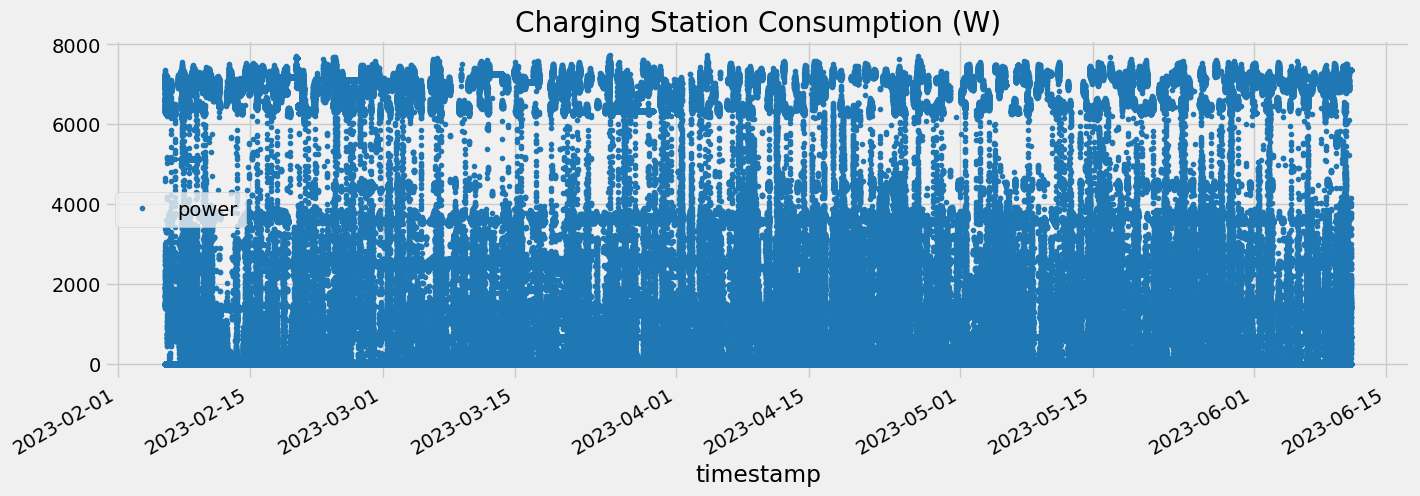

In [9]:
df1.plot(style='.',
         figsize=(15, 5),
         color=color_pal[0],
         title='Charging Station Consumption (W)'
         )
plt.show()


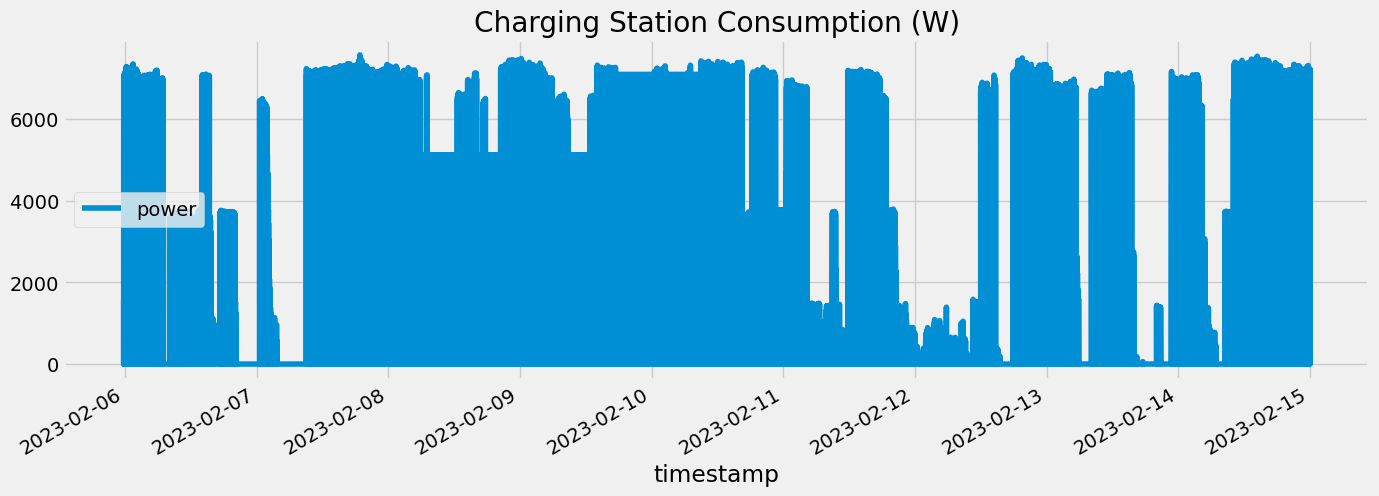

In [8]:
df1.loc[(df1.index > '2023-02-01') & (df1.index < '2023-02-15')].plot(
    figsize=(15, 5),
    title='Charging Station Consumption (W)'
)
plt.show()


## Train / Test Split

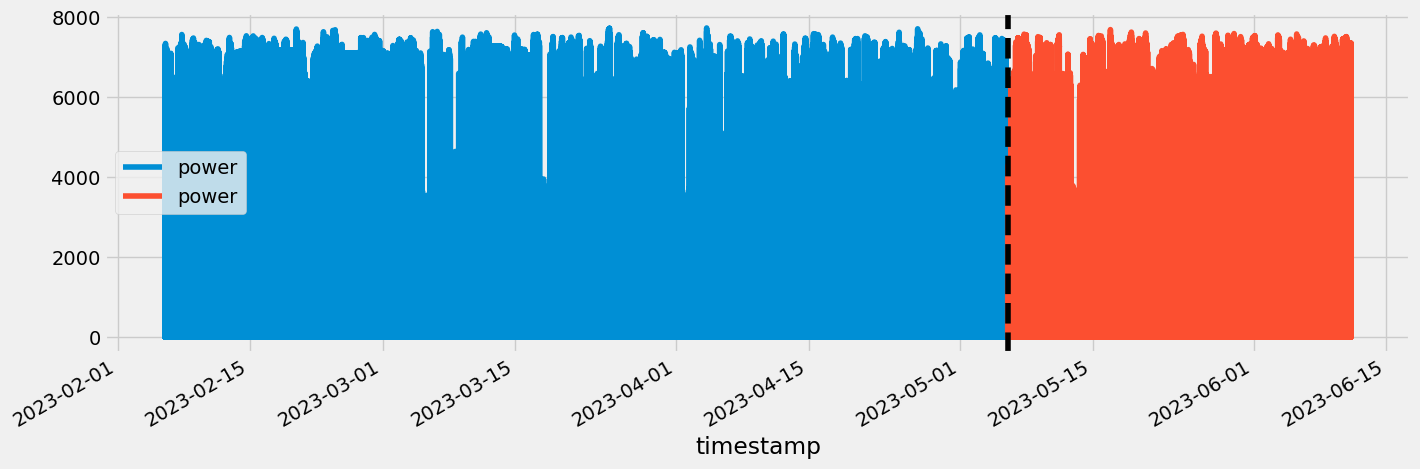

In [70]:
train = df1.loc[df1.index < '2023-05-06']
test = df1.loc[df1.index >= '2023-05-06']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2023-05-06', color='black', ls='--')
plt.show()


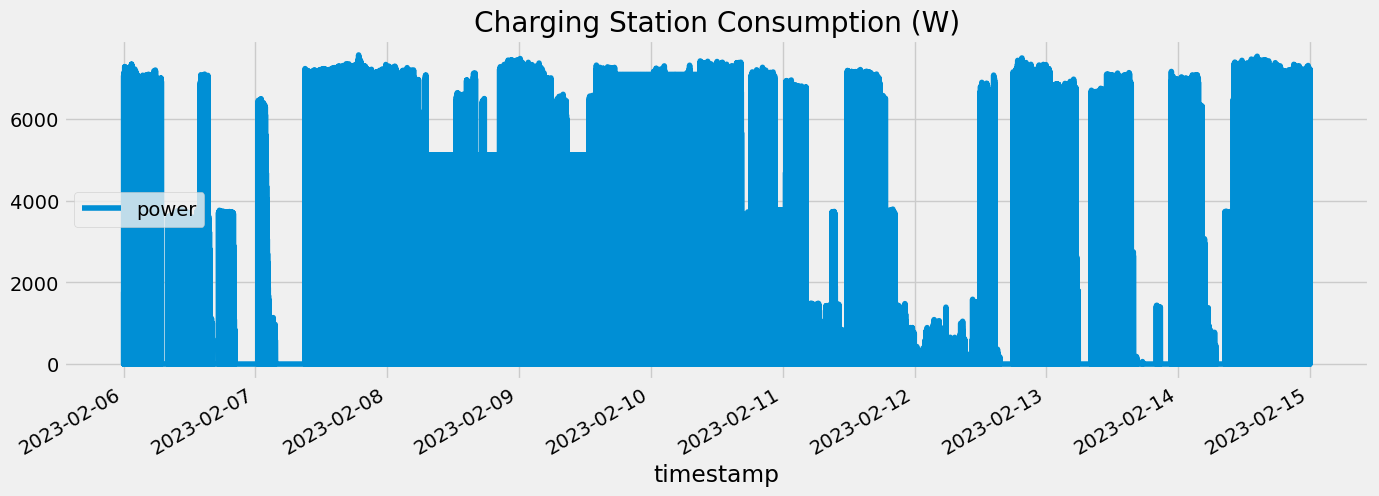

In [17]:
df1.loc[(df1.index > '2023-02-06') & (df1.index < '2023-02-15')].plot(
    figsize=(15, 5),
    title='Charging Station Consumption (W)'
)
plt.show()

## FC

In [71]:
def features(df1):
    """
    Create time series features
    """
    #df1 = df.copy
    df1['hour'] = df1.index.hour
    df1['dayofweek'] = df1.index.dayofweek
    df1['month'] = df1.index.month
    df1['dayofyear'] = df1.index.dayofyear
    return df1




### Visualize feature / Target relationship

In [75]:
df1 = features(df1)
df1['hour'].head()

timestamp
2023-05-01 16:25:12    16
2023-05-01 16:25:12    16
2023-05-01 16:25:12    16
2023-05-01 16:25:12    16
2023-05-01 16:25:12    16
Name: hour, dtype: int64

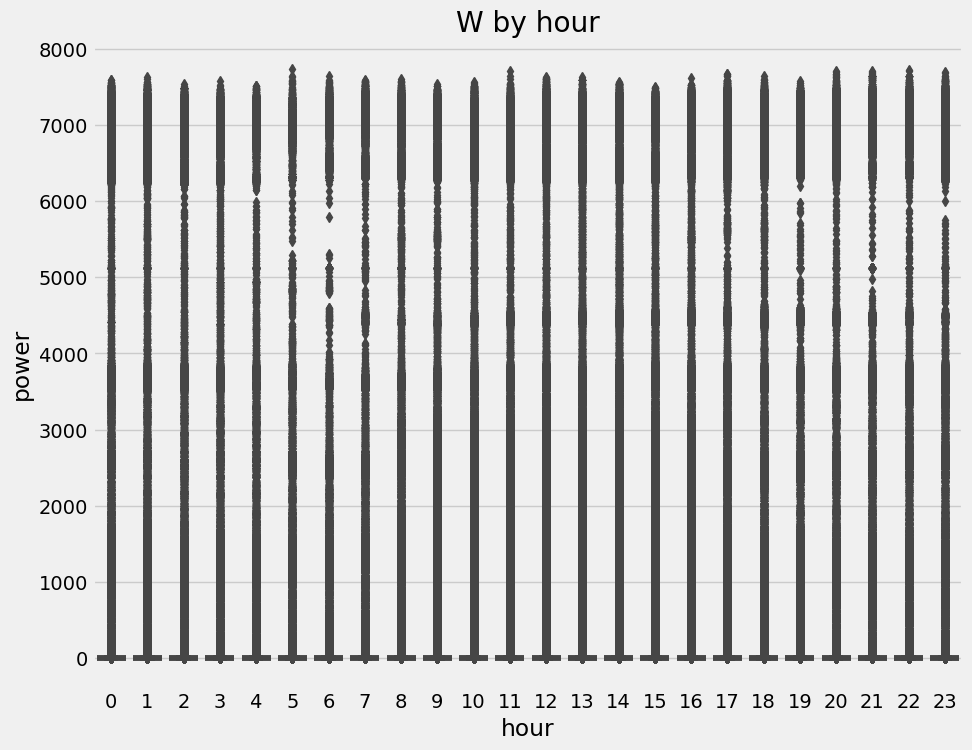

In [58]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df1, x='hour', y='power')
ax.set_title('W by hour')
plt.show()

# Model

In [76]:
train = features(train)
test = features(test)
features = ['hour', 'dayofweek', 'month', 'dayofyear']
target = 'power'

C:\Users\General\AppData\Local\Temp\ipykernel_10476\3192220936.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['hour'] = df1.index.hour
C:\Users\General\AppData\Local\Temp\ipykernel_10476\3192220936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dayofweek'] = df1.index.dayofweek
C:\Users\General\AppData\Local\Temp\ipykernel_10476\3192220936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [79]:
X_train = train[features]
y_train = train[target] 

X_test = test[features]
y_test = test[target] 

In [83]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
eval_set=[(X_train, y_train), (X_test, y_test)],
verbose=True
)


[0]	validation_0-rmse:1205.89143	validation_1-rmse:1105.27403
[1]	validation_0-rmse:1204.95984	validation_1-rmse:1104.52983
[2]	validation_0-rmse:1204.05519	validation_1-rmse:1103.77452
[3]	validation_0-rmse:1203.16785	validation_1-rmse:1103.09837
[4]	validation_0-rmse:1202.29715	validation_1-rmse:1102.37221
[5]	validation_0-rmse:1201.44350	validation_1-rmse:1101.72318
[6]	validation_0-rmse:1200.59635	validation_1-rmse:1101.04410
[7]	validation_0-rmse:1199.77484	validation_1-rmse:1100.41829
[8]	validation_0-rmse:1198.96928	validation_1-rmse:1099.73958
[9]	validation_0-rmse:1198.17545	validation_1-rmse:1098.99257
[10]	validation_0-rmse:1197.39975	validation_1-rmse:1098.40388
[11]	validation_0-rmse:1196.65049	validation_1-rmse:1097.82668
[12]	validation_0-rmse:1195.91552	validation_1-rmse:1097.24478
[13]	validation_0-rmse:1195.19470	validation_1-rmse:1096.68964
[14]	validation_0-rmse:1194.48776	validation_1-rmse:1096.12763
[15]	validation_0-rmse:1193.78588	validation_1-rmse:1095.59374
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)